## **Data retrieval and processing**


In [11]:
import numpy as np
import scipy.io as io
import os

data_path = os.path.join(os.getcwd(),'data')
# loading train and test files
train_5 = io.loadmat(os.path.join(data_path,'training_data_5.mat'))['train_data_5']
train_6 = io.loadmat(os.path.join(data_path,'training_data_6.mat'))['train_data_6']
test_5 = io.loadmat(os.path.join(data_path,'testing_data_5.mat'))['test_data_5']
test_6 = io.loadmat(os.path.join(data_path,'testing_data_6.mat'))['test_data_6']

# coverting each image to a obj-feat datamatrix by flattening each image
train_feat_5 = np.array([i.flatten() for i in train_5])
train_feat_6 = np.array([i.flatten() for i in train_6])
test_feat_5 = np.array([i.flatten() for i in test_5])
test_feat_6 = np.array([i.flatten() for i in test_6])

# getting labelled data
train_lab_5 = np.hstack([train_feat_5, np.full((train_feat_5.shape[0], 1), 5)])
train_lab_6 = np.hstack([train_feat_6, np.full((train_feat_6.shape[0], 1), 6)])
test_lab_5 = np.hstack([test_feat_5, np.full((test_feat_5.shape[0], 1), 5)])
test_lab_6 = np.hstack([test_feat_6, np.full((test_feat_6.shape[0], 1), 6)])

# data with labels
train_lab_data = np.concatenate((train_lab_5, train_lab_6))
test_lab_data = np.concatenate((test_lab_5, test_lab_6))
    

In [12]:
# getting grouped data and labels
train_data = train_lab_data[:,:-1]
test_data = test_lab_data[:,:-1]
train_labs = train_lab_data[:,-1]
test_labs = test_lab_data[:,-1]

## **Task 1**
### Feature normalization

In [13]:
mean_vec = np.mean(train_data, axis=0)
std_vec = np.std(train_data, axis=0)
norm_train = np.where(std_vec != 0, (train_data - mean_vec) / std_vec, 0)

/var/folders/p0/jsns01ks7f73zhhl3nph3qy80000gn/T/ipykernel_14729/1663451352.py:3: RuntimeWarning: invalid value encountered in divide
  norm_train = np.where(std_vec != 0, (train_data - mean_vec) / std_vec, 0)


## **Task 2**
#### PCA on training data

In [14]:
# defining covariance matrix calculation
def cov_matrix(x: np.ndarray) -> np.ndarray:
    
    mean_vec = np.mean(x, axis=0)
    centered_matrix = x - mean_vec
    
    cov = (centered_matrix.T @ centered_matrix)/(len(x)-1)
    
    return cov

# defining function to select principal components
def pc_selection(eval:np.ndarray, evec:np.ndarray)->(np.ndarray, np.ndarray):
    
    threshold = 0.95
    cum_var_ratio = np.cumsum(eval) / np.sum(eval)
    k = np.argmax(cum_var_ratio >= threshold) + 1
    return eval[:k], evec[:, :k]

In [15]:
norm_cov_mat = cov_matrix(norm_train)
norm_eigvals, norm_eigvecs= np.linalg.eigh(norm_cov_mat)
    
sorted_indices = np.argsort(norm_eigvals)[::-1]
norm_eigvals = norm_eigvals[sorted_indices]
norm_eigvecs = norm_eigvecs[:, sorted_indices]

## **Task 3**
### PCA dimension reduction

In [16]:
# nomralized data reduced
dimred_train_normdata = norm_train@norm_eigvecs[:,:2]

In [17]:
# original data reduced
cov_mat = cov_matrix(train_data)
eigvals, eigvecs= np.linalg.eigh(cov_mat)
    
sorted_indices = np.argsort(eigvals)[::-1]
eigvals = eigvals[sorted_indices]
eigvecs = eigvecs[:, sorted_indices]
dimred_train_data = train_data@eigvecs[:,:2]

plotting to compare data after normalization vs before normalization

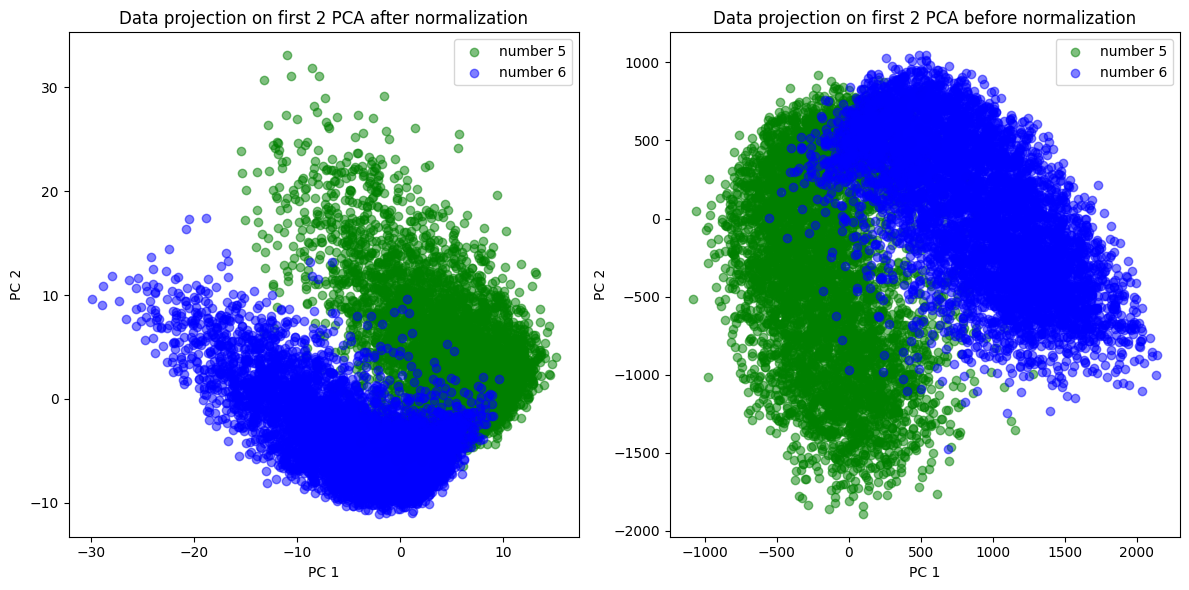

In [18]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plotting PCA data plot with normalization on the first axis (ax1)
ax1.scatter(
    dimred_train_normdata[train_labs==5][:, 0],
    dimred_train_normdata[train_labs==5][:, 1],
    alpha=0.5,
    label='number 5',
    color='green'
)
ax1.scatter(
    dimred_train_normdata[train_labs==6][:, 0],
    dimred_train_normdata[train_labs==6][:, 1],
    alpha=0.5,
    label='number 6',
    color='blue'
)
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')
ax1.set_title('Data projection on first 2 PCA after normalization')
ax1.legend()

# Checking PCA data plot without normalization on the second axis (ax2)
ax2.scatter(
    dimred_train_data[train_labs==5][:, 0],
    dimred_train_data[train_labs==5][:, 1],
    alpha=0.5,
    label='number 5',
    color='green'
)
ax2.scatter(
    dimred_train_data[train_labs==6][:, 0],
    dimred_train_data[train_labs==6][:, 1],
    alpha=0.5,
    label='number 6',
    color='blue'
)
ax2.set_xlabel('PC 1')
ax2.set_ylabel('PC 2')
ax2.set_title('Data projection on first 2 PCA before normalization')
ax2.legend()

plt.tight_layout()  # To ensure that the plots do not overlap
plt.show()


## **Task 4**
### Density estimation

Here we calculate the MLE expressions for the mean and variance for the distributions and apply them to  our data

**Mean MLE**:
Given data samples \( x_1, x_2, ..., x_N \), the MLE for the mean \( \mu \) is:

\[
\mu_{\text{MLE}} = \frac{1}{N} \sum_{i=1}^{N} x_i
\]

**Variance MLE**:
Given data samples \( x_1, x_2, ..., x_N \), the MLE for the variance \( \sigma^2 \) is:

\[
\sigma^2_{\text{MLE}} = \frac{1}{N} \sum_{i=1}^{N} (x_i - \mu_{\text{MLE}})^2
\]

calculating parameters based on the above expressions

In [24]:
digit5_data = dimred_train_normdata[train_labs==5]
digit6_data = dimred_train_normdata[train_labs==6]

# estimated parameters
digit5_mean, digit5_cov = np.mean(digit5_data, axis=0), cov_matrix(digit5_data)
digit6_mean, digit6_cov = np.mean(digit6_data, axis=0), cov_matrix(digit6_data)

print('digit 5 parameters:\nmean: \n', digit5_mean, '\ncov: \n', digit5_cov)
print('\ndigit 6 parameters:\nmean: \n', digit6_mean, '\ncov: \n', digit6_cov)

digit 5 parameters:
mean: 
 [4.4531976  4.06950581] 
cov: 
 [[ 23.39752387 -15.13656603]
 [-15.13656603  36.44251424]]

digit 6 parameters:
mean: 
 [-4.07921328 -3.72774434] 
cov: 
 [[ 42.26834766 -17.94685568]
 [-17.94685568  18.33380651]]


## **Task 5**
### Bayesian Decision Theory for optimal classification